<h1 align="center">Mathematical Methods in Engineering - Course Code: 25872</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2023</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Questions 1 & 2: [Zahra maleki](https://t.me/Rosebaekfany), Questions 3: [Radin Khayyam](https://t.me/Radinkhayyam)

</h4>

<p>
    Write your code in the <span style="color: green;">Code Cell</span> and run the <span style="color: green;">Evaluation Cell</span> to check the output.<br>
    <span style="color: red; font-weight: bold;">Please refrain from editing the existing codes.</span>
</p>


In [ ]:
Name = "Sajad Ghafouri"
Student_Number = "401102189"

### Importing necessary libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from PIL import Image
import time
from numpy import asarray
from sklearn.utils.extmath import randomized_svd
import requests

In [2]:
np.random.RandomState(0)

RandomState(MT19937) at 0x160EE3B40

## Problem 1: SVD for Compression ``(35 pt.)``

In this question, we want to compress BMP images using SVD. BMP images are not compressed by default and the pixel information is stored in rather a simple format. Colored BMP files are composed of three matrices of size $n × m$ where $n$ and $m$ are the height and width of the image, respectively. Each matrix corresponds to one of the three colors Red, Green, and Blue. Each entry of these matrices is a number between 0 and 255 that specifies the intensity of the corresponding color. The final array is hence a 3D array of size $n × m × 3$.

### 1.1 Image display
Choose two arbitrary BMP files (it is recommended to use different subjects and sizes) and load it into a `numpy` array using the `imread` function. Then, show each image and display their shape.

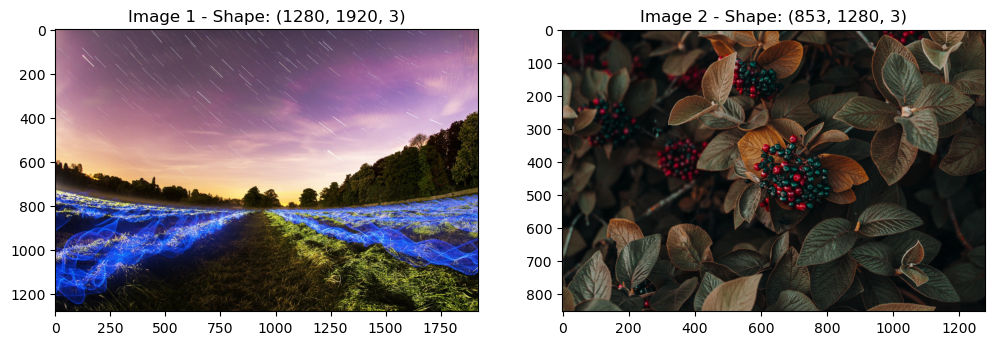

In [3]:
from matplotlib.image import imread

image1 = imread('sample_1920×1280.bmp')
image2 = imread('dwsample-bmp-1280.bmp')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title(f'Image 1 - Shape: {image1.shape}')

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title(f'Image 2 - Shape: {image2.shape}')

plt.show()

### 1.2 Singular Value Decomposition and channel seperation

Calculate the SVD decomposition of each of ech RGB channel.

$$
A = U \Sigma V^T
$$
where $A$ is the original array, $U$ is an $n × n$ unitary matrix, $\Sigma$ is an $n × m$ rectangular diagonal matrix with non-negative real numbers on the diagonal, and $V$ is an $m × m$ unitary matrix.

In [5]:
from numpy.linalg import svd

def compute_svd(image):
    U = {}
    S = {}
    V = {}
    
    for channel, color in enumerate(['R', 'G', 'B']):
        U[color], S[color], V[color] = svd(image[:, :, channel], full_matrices=False)
    
    return U, S, V

U1, S1, V1 = compute_svd(image1)
U2, S2, V2 = compute_svd(image2)

### 1.3 compressing the image

Since eigenvalues in the decomposition are sorted in descending order, we can approximate the original array by keeping only the first $k$ columns of $U$, first $k$ rows and columns of $\Sigma$, and first $k$ rows of $V^T$.
Select $k$ to be (5, 10, 20, 30, 50, 100, 200, 250) and approximate the original array using the truncated SVD. Show the approximated image titled with the value of $k$.

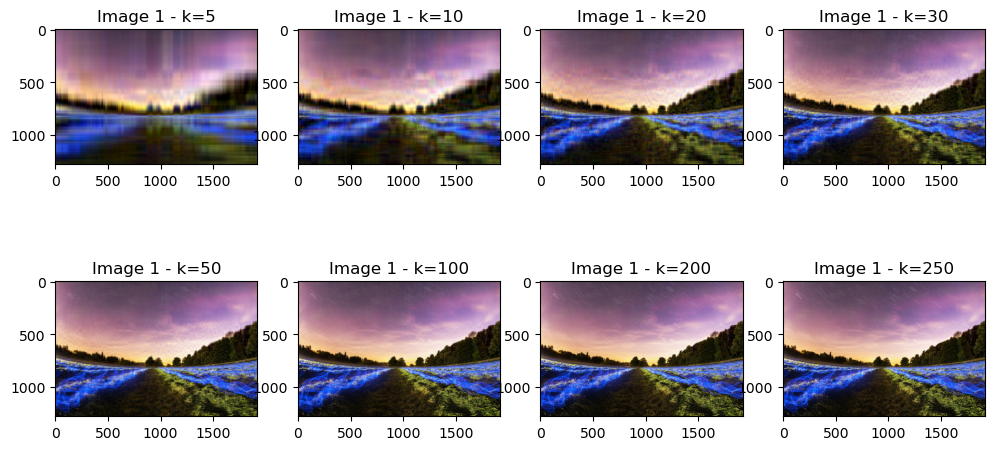

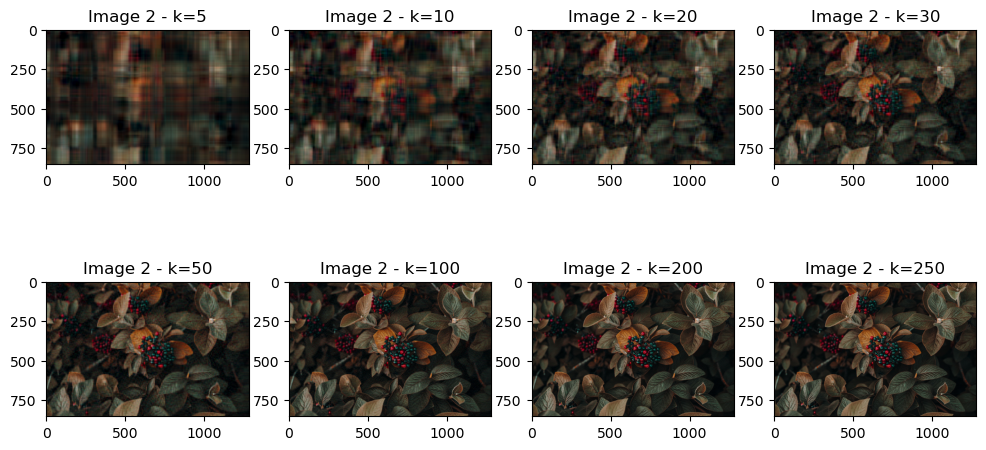

In [15]:
def reconstruct_image(U, S, V, k):
    reconstructed_channels = []
    for color in ['R', 'G', 'B']:
        U_k = U[color][:, :k]
        S_k = np.diag(S[color][:k])
        V_k = V[color][:k, :]
        reconstructed_channel = np.dot(U_k, np.dot(S_k, V_k))
        reconstructed_channels.append(reconstructed_channel)
    
    reconstructed_image = np.stack(reconstructed_channels, axis=2)
    return np.clip(reconstructed_image, 0, 255).astype(np.uint8)

k_values = [5, 10, 20, 30, 50, 100, 200, 250]

for i, image_data in enumerate([(image1, U1, S1, V1), (image2, U2, S2, V2)], start=1):
    plt.figure(figsize=(12, 6))
    for j, k in enumerate(k_values):
        reconstructed_image = reconstruct_image(image_data[1], image_data[2], image_data[3], k)
        plt.subplot(2, 4, j + 1)
        plt.imshow(reconstructed_image)
        plt.title(f'Image {i} - k={k}')
    plt.show()

#### explion your results.

Explain the relationship between the number of components and the level of compression in the images. How does the image quality change with increasing values of k?

By increasing values of k, the image quality improves because more singular values are used to reconstruct the image. As k increases, the approximation becomes closer to the original image. At very low values of k, the image appears blurry and loses fine details. At higher values of k, the image quality is significantly better.

### 1.4 variance

there is no need to store $U$ and $V$ matrices. Instead, we can store $\Sigma$ and two other matrices of size $n × k$ and $m × k$. Using $\Sigma$ display the plots below. To not compress the image based on a given random number k, we are required to do some math & statistics

1. The plot "Component Importance" shows the  amount  of variance each component carries. The first component preserves the highest variance, then the second, and so on.
2. The plot shows the explained variance as a function of numbers, using this technique you can choose how much the image, relative to its original size gets compressed.

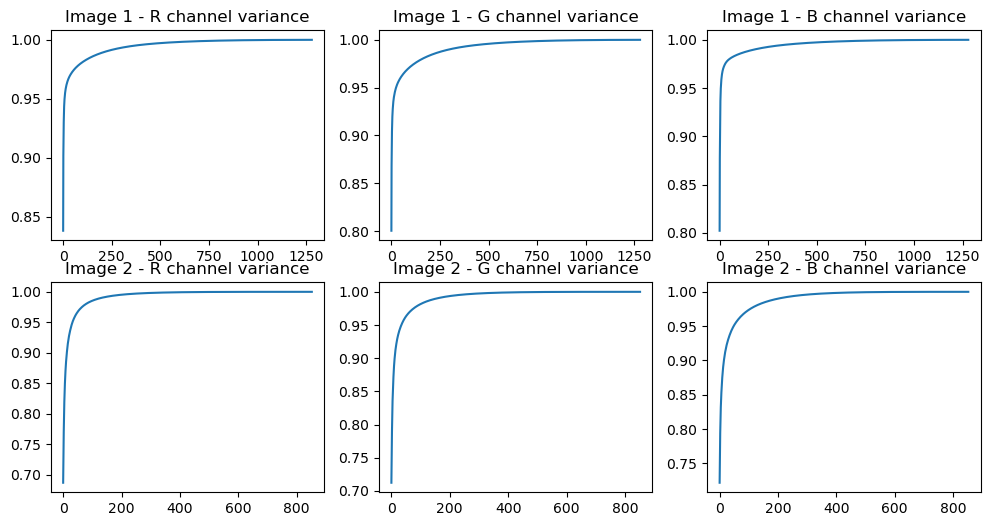

In [29]:
def plot_variance(S):
    variances = []
    for color in ['R', 'G', 'B']:
        singular_values = S[color]
        explained_variance = np.cumsum(singular_values ** 2) / np.sum(singular_values ** 2)
        variances.append(explained_variance)
        
    return variances

def compress_with_variance(U, S, V, variance_threshold):
    k_values = {}
    for color in ['R', 'G', 'B']:
        explained_variance = np.cumsum(S[color] ** 2) / np.sum(S[color] ** 2)
        k_values[color] = np.argmax(explained_variance >= variance_threshold) + 1
        
    max_k = max(k_values.values())
    return reconstruct_image(U, S, V, max_k), max_k

plt.figure(figsize=(12, 6))
for i, S in enumerate([S1, S2], start=1):
    variances = plot_variance(S)
    for j, color in enumerate(['R', 'G', 'B']):
        plt.subplot(2, 3, (i-1)*3 + j + 1)
        plt.plot(variances[j])
        plt.title(f'Image {i} - {color} channel variance')

plt.show()

Compress the image with 90% of its explained variance ratio and show the result image.

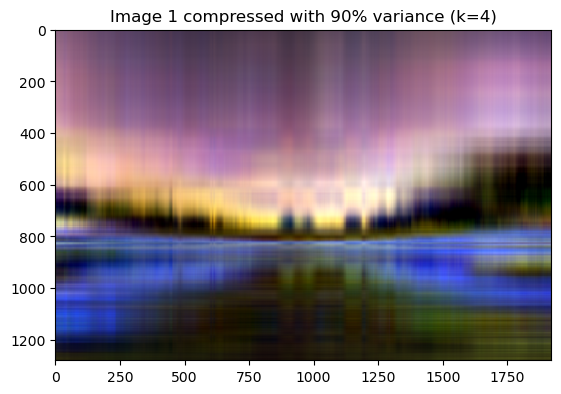

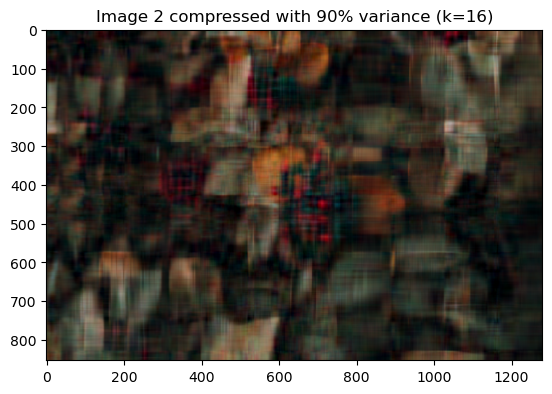

In [35]:
for i, (U, S, V) in enumerate([(U1, S1, V1), (U2, S2, V2)], start=1):
    compressed_image, k = compress_with_variance(U, S, V, 0.9)
    plt.imshow(compressed_image)
    plt.title(f'Image {i} compressed with 90% variance (k={k})')
    plt.show()

## Problem 2 ``(30 pt.)``

### 2.1 Truncate the SVD
Write the function of truncated_svd

In [36]:
def truncated_svd(A, k):
    U, S, VT = svd(A, full_matrices=False)
    U_k = U[:, :k]
    S_k = S[:k]
    VT_k = VT[:k, :]
    return U_k, S_k, VT_k

### 2.2 Randomized SVD

In the following cell, you should implement the randomized SVD for the input matrix. The number of empty lines below suggests the number of lines needed for a possible solution.

In [37]:
def sqr(A):
    Q, R = linalg.qr(A,mode="economic")
    return Q, R

In [38]:
def rsvd(A, n_components, random_state, n_oversamples=10, n_iter=4):
    np.random.seed(random_state)
    ny = A.shape[1]

    P = np.random.randn(ny, n_components + n_oversamples)
    Z = A @ P

    for _ in range(n_iter):
        Z = A @ (A.T @ Z)

    Q, R = sqr(Z)

    Y = Q.T @ A
    U1, S, VT = svd(Y, full_matrices=False)
    U = Q @ U1

    return U[:, :n_components], S[:n_components], VT[:n_components, :]

In the following cell, implement the rsvd as you did before but this time use the LU decomposition instead of the multiplication of matrices.

In [47]:
from sklearn.utils.extmath import randomized_svd

def nrsvd(A, n_components, random_state, n_oversamples=10, n_iter=4):
    U, s, Vh = randomized_svd(A, n_components=n_components, n_oversamples=n_oversamples, n_iter=n_iter, random_state=random_state)
    return U[:, :n_components], s[:n_components], Vh[:n_components, :]


This function performs the randomized SVD of sklearn library. Do not change this cell.

In [48]:
def srsvd(A, n_components, random_state, n_oversamples, n_iter):
  U, s, Vh = randomized_svd(A, n_components=n_components, random_state=random_state, n_oversamples=n_oversamples, n_iter=n_iter)
  return U[:, :n_components], s[:n_components], Vh[:n_components, :]

In order to test your randomized SVD code, please run the following cell. It contains test cases to verify the correctness of your implementation.

In [49]:
def make_matrix(m,n,k,randomstate):
    n_rows = m
    n_cols = n
    t = int(n_rows*n_cols*k)
    np.random.RandomState(randomstate)
    rr = np.random.choice(np.arange(0,n_rows),t)
    cr = np.random.choice(np.arange(0,n_cols),t)
    M = np.zeros((n_rows,n_cols))
    M[rr,cr]= 1
    return M

def base_rsvd(rsvdscipy,att):
  err = [0]*len(att)
  tim = [0]*len(att)
  for i in range(len(att)):
    M = make_matrix(att[i][0],att[i][1],0.01,att[i][3])
    start_time = time.time()
    U, s, Vh = rsvdscipy(M,att[i][2],att[i][3],att[i][4],att[i][5])
    time_length = time.time() - start_time
    M_rec = U @ np.diag(s) @ Vh
    error = np.linalg.norm(M - M_rec, ord='fro')/np.linalg.norm(M, ord='fro')
    err[i] = error
    tim[i] = time_length
    print(f"srsvd test {i+1}: error: {error:.3f}, time: {time_length:.3f}")
  print("-------------------------------")
  return err,tim

def test_rsvd(rsvdscipy,svd1):
  att = [(3000,3000,500,0,10,4),(1500,1400,500,0,10,5),(2000,5000,400,0,10,7),(6000,2600,400,0,10,3)]
  err,tim = base_rsvd(rsvdscipy,att)
  for i in range(4):
    M = make_matrix(att[i][0],att[i][1],0.01,att[i][3])
    start_time = time.time()
    U, s, Vh = svd1(M,att[i][2],att[i][3],att[i][4],att[i][5])
    time_length = time.time() - start_time
    M_rec = U @ np.diag(s) @ Vh
    error = np.linalg.norm(M - M_rec, ord='fro')/np.linalg.norm(M, ord='fro')
    if error > err[i]+0.1:
      print(f"Test{i+1}, Alg rsvd: \033[31mFailed!\033[0m because of error \n with Error {error:.3f} and time {time_length:.3f} \n ------------------")
    elif time_length > tim[i]+0.5:
      print(f"Test{i+1}, Alg rsvd: \033[31mFailed!\033[0m because of time \n with Error {error:.3f} and time {time_length:.3f} \n ------------------")
    else:
      print(f"Test{i+1}, Alg rsvd: \033[32mPassed!\033[0m \n with Error {error:.3f} and time {time_length:.3f} \n ------------------")

In [50]:
test_rsvd(srsvd,rsvd)

srsvd test 1: error: 0.728, time: 0.975
srsvd test 2: error: 0.487, time: 0.453
srsvd test 3: error: 0.769, time: 1.142
srsvd test 4: error: 0.823, time: 0.972
-------------------------------
Test1, Alg rsvd: Passed! 
 with Error 0.728 and time 0.747 
 ------------------
Test2, Alg rsvd: Passed! 
 with Error 0.486 and time 0.295 
 ------------------
Test3, Alg rsvd: Passed! 
 with Error 0.769 and time 0.962 
 ------------------
Test4, Alg rsvd: Passed! 
 with Error 0.823 and time 0.782 
 ------------------


Here you can visualize the result of various svd methods on a cat image. You can also compare the time it takes for each method to run.

In [51]:
url = 'https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?cs=srgb&dl=pexels-pixabay-45201.jpg&fm=jpg'
img = Image.open(requests.get(url, stream=True).raw)

rgb_image = asarray(img)
gray_image = np.average(rgb_image, axis=2, weights=[0.2989, 0.5870, 0.1140])

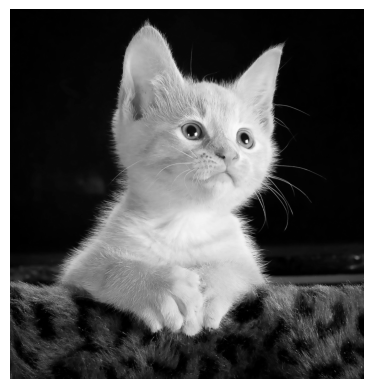

In [52]:
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

In [53]:
def show_images(im,k):
  start_time = time.time()
  U, s, Vh = linalg.svd(im)
  image1 = U[:, :k] @ np.diag(s[:k]) @ Vh[:k, :]
  t1 = time.time()-start_time
  start_time = time.time()
  U, s, Vh = rsvd(im,k,0,10,4)
  image2 = U @ np.diag(s) @ Vh
  t2 = time.time()-start_time
  start_time = time.time()
  U, s, Vh = nrsvd(im,k,0,10,4)
  image3 = U @ np.diag(s) @ Vh
  t3 = time.time()-start_time
  start_time = time.time()
  U, s, Vh = srsvd(im,k,0,10,4)
  image4 = U @ np.diag(s) @ Vh
  t4 = time.time()-start_time

  fig, axes = plt.subplots(nrows=2, ncols=2)

  axes[0, 0].imshow(image1, cmap='gray')
  axes[0, 0].set_title(f'svd, t = {t1:.2f}s')
  axes[0, 0].axis('off')
  axes[0, 1].imshow(image2, cmap='gray')
  axes[0, 1].set_title(f'rsvd, t = {t2:.2f}s')
  axes[0, 1].axis('off')
  axes[1, 0].imshow(image3, cmap='gray')
  axes[1, 0].set_title(f'nrsvd, t = {t3:.2f}s')
  axes[1, 0].axis('off')
  axes[1, 1].imshow(image4, cmap='gray')
  axes[1, 1].set_title(f'srsvd, t = {t4:.2f}s')
  axes[1, 1].axis('off')

  plt.tight_layout()
  plt.show()


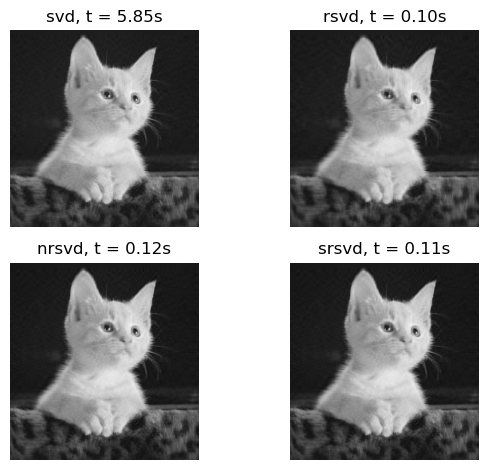

In [54]:
show_images(gray_image,50)

## Problem 3: PCA and its applications ``(50 pt.)``


Principal Component Analysis (PCA) is a statistical technique commonly used in data analysis and machine learning for dimensionality reduction while preserving as much variance as possible. It helps in identifying patterns in data based on the correlation between features. The goal of PCA is to reduce the number of variables of a data set, while preserving as much information (variance) as possible.

### Step 1: Standardize the Dataset
Normalize each feature in the dataset to have zero mean and unit variance to ensure each feature contributes equally:

\begin{align}
z_i = \frac{(x_i - \mu)}{\sigma}
\end{align}

### Step 2: Compute the Covariance Matrix
Construct a covariance matrix to analyze how features vary from the mean with respect to each other, which helps in identifying correlated features:

\begin{align}
C = \frac{1}{n-1} \times (X^T X)
\end{align}

where \( X \) is the standardized data matrix.

### Step 3: Calculate Eigenvalues and Eigenvectors
Solve for eigenvalues and their corresponding eigenvectors of the covariance matrix; these will determine the new axes (principal components) for the data projection:

\begin{align}
Cv = \lambda v
\end{align}

### Step 4: Sort Eigenvalues and Eigenvectors
Order the eigenvalues from largest to smallest and rank the eigenvectors accordingly. This ranking indicates the relative significance of each principal component.

### Step 5: Project Data onto Principal Components
Transform the original dataset into a new coordinate system by projecting it onto the principal eigenvectors, reducing dimensionality while retaining most of the variance:

\begin{align}
Y = XW
\end{align}

Here, \( W \) is the matrix containing the selected eigenvectors, and \( Y \) is the transformed data matrix. This final transformation results in a new dataset that highlights the most significant relationships within the original data.

---
In the section below, import all the libraries you need:

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

The MNIST dataset is a large collection of handwritten digits commonly used for training various image processing systems. It contains 70,000 images of handwritten digits from 0 to 9, each represented as a 28x28 pixel grayscale image.

load the dataset and show the first 50 samples:

In [73]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 38s 3us/step


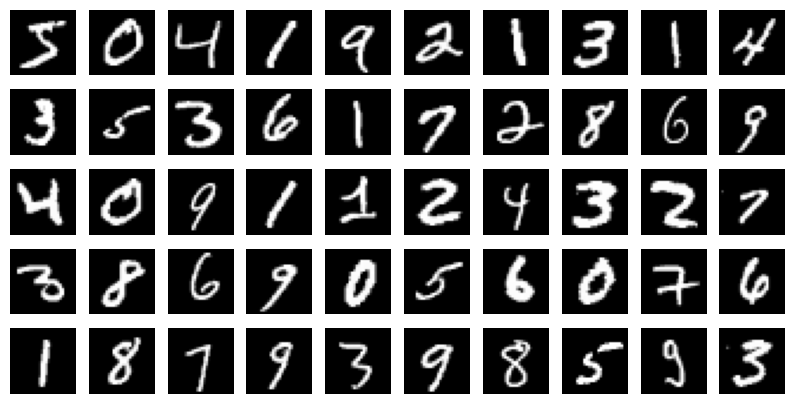

In [74]:
fig, axes = plt.subplots(5, 10, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[i], cmap='gray')
    ax.axis('off')
plt.show()

PCA is affected by scale, so you need to do some normalization on data before applying PCA.

1- Reshape the data from a 28x28 matrix to a flattened 784-element vector.

2- Subtract the mean and divide by the standard deviation for each sample.


In [75]:
x_train = x_train.reshape((x_train.shape[0], -1)) 
x_test = x_test.reshape((x_test.shape[0], -1))

x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_std[x_train_std == 0] = 1 
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In this section, first obtain the covariance matrix of the data and then extract its eigenvalues and eigenvectors. Finally, sort the eigenvalues and their corresponding eigenvectors from largest to smallest.

In [76]:
cov_matrix = np.cov(x_train, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

Now, we want to examine how many components can represent 75 percent of the total variance of the data. Note that the variance of each component corresponds to its eigenvalue.

In [84]:
total_variance = np.sum(eigenvalues)
variance_75 = total_variance * 0.75
cumulative_variance = np.cumsum(eigenvalues)
n_components_75 = np.argmax(cumulative_variance >= variance_75) + 1

print(f'Number of components to retain 75% variance: {n_components_75}')

W_75 = eigenvectors[:, :n_components_75]
x_train_pca = np.dot(x_train, W_75)
x_test_pca = np.dot(x_test, W_75)

Number of components to retain 75% variance: 120


Now in this section, project the available data onto these components, perform dimensionality reduction, and then return the dimensions to the size of the original images. Draw an image of one of the samples for both states: before dimension reduction on the components and after it.

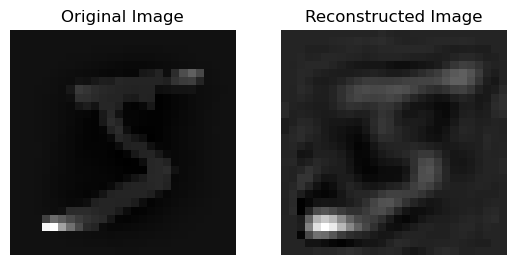

In [85]:
x_train_reconstructed = np.dot(x_train_pca, W_75.T)

index = 0
original_image = x_train[index].reshape(28, 28)
reconstructed_image = x_train_reconstructed[index].reshape(28, 28)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(reconstructed_image, cmap='gray')
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')

plt.show()

In this section, define a classifier such as SVM or RandomForest, and use the test and training data to determine the accuracy of the classifier. Repeat this process for different numbers of components and examine the impact of increasing the number of components on accuracy. Note that in this section, you can use built-in functions for performing PCA and classification. Additionally, identify which number of components results in the best accuracy.

In [96]:
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def do_pca(n_components, data):
    ipca = IncrementalPCA(n_components=n_components, batch_size=1000)
    return ipca.fit_transform(data)

In [98]:
def ML_model(X_train, y_train, X_test, y_test):
    classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

Number of components: 2, Accuracy: 0.0958
Number of components: 12, Accuracy: 0.1029
Number of components: 22, Accuracy: 0.091
Number of components: 32, Accuracy: 0.0698
Number of components: 42, Accuracy: 0.152
Number of components: 52, Accuracy: 0.1263
Number of components: 62, Accuracy: 0.1404
Number of components: 72, Accuracy: 0.1036
Number of components: 82, Accuracy: 0.0951
Number of components: 92, Accuracy: 0.1107


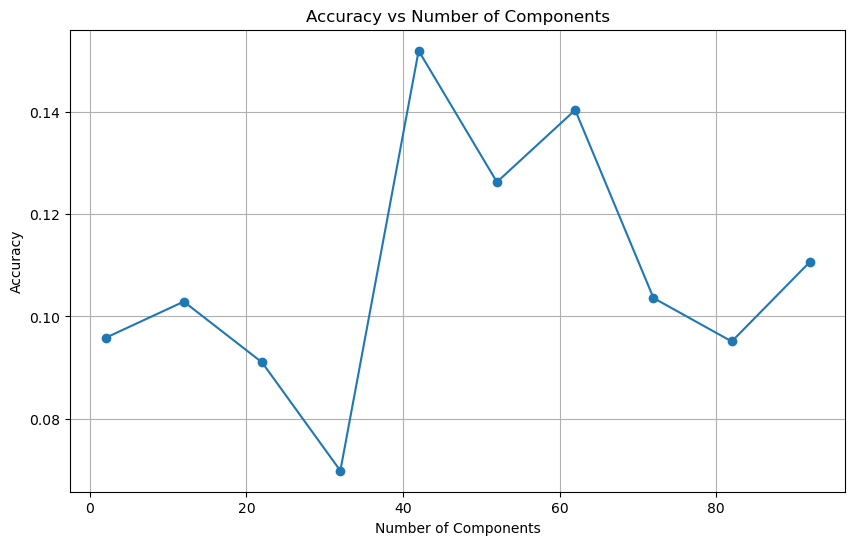

In [99]:
x_train, x_test = (x_train - x_train_mean) / x_train_std, (x_test - x_train_mean) / x_train_std

accuracies = []
components_range = range(2, 102, 10) 

X_train_chunk, _, y_train_chunk, _ = train_test_split(x_train, y_train, train_size=10000, stratify=y_train)

for n_components in components_range:
    x_train_pca = do_pca(n_components, X_train_chunk)
    x_test_pca = do_pca(n_components, x_test)
    accuracy = ML_model(x_train_pca, y_train_chunk, x_test_pca, y_test)
    accuracies.append(accuracy)
    print(f"Number of components: {n_components}, Accuracy: {accuracy}")

plt.figure(figsize=(10, 6))
plt.plot(components_range, accuracies, marker='o')
plt.title('Accuracy vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()